In [1]:

#import library
import os
import numpy as np

import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import scipy.io as scio 
import scipy.io as sio
from tf_utils import random_mini_batches, convert_to_one_hot
from tensorflow.python.framework import ops



In [2]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def create_placeholders(n_x, n_y):

    isTraining = tf.placeholder_with_default(True, shape=())
    x_in = tf.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = tf.placeholder(tf.float32, [None, n_y], name = "y_in")
    mask_train = tf.placeholder(tf.float32, name = "mask_train")
    mask_test = tf.placeholder(tf.float32, name = "mask_test")
    lap = tf.placeholder(tf.float32, [None, None], name = "lap")
    
    return x_in, y_in, lap, mask_train, mask_test, isTraining

def initialize_parameters():
   
    tf.set_random_seed(1)

    x_w1 = tf.get_variable("x_w1", [200,128], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b1 = tf.get_variable("x_b1", [128], initializer = tf.zeros_initializer())
     
    x_w2 = tf.get_variable("x_w2", [128,16], initializer = tf.keras.initializers.glorot_normal(seed = 1))
    x_b2 = tf.get_variable("x_b2", [16], initializer = tf.zeros_initializer())
    
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}
                  
    return parameters

def GCN_layer(x_in, L_, weights):

    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.name_scope("x_layer_1"):
        
         x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)          
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)   
         x_a1 = tf.nn.relu(x_z1_bn)     

    with tf.name_scope("x_layer_2"):
         
         x_z2_bn = tf.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)            
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']         
         
    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
                
    return x_z2, l2_loss

def mynetwork_optimaization(y_est, y_re, l2_loss, mask, reg, learning_rate, global_step):
    
    with tf.name_scope("cost"):
         cost = (tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = y_re)) +  reg * l2_loss
         mask = tf.cast(mask, dtype = tf.float32)
         mask /= tf.reduce_mean(mask)
         cost *= mask
         cost = tf.reduce_mean(cost) +  reg * l2_loss
         
    with tf.name_scope("optimization"):
         update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer

def masked_accuracy(preds, labels, mask):

      correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
      accuracy = tf.cast(correct_prediction, "float")
      mask = tf.cast(mask, dtype = tf.float32)
      mask /= tf.reduce_mean(mask)
      accuracy *= mask
      
      return tf.reduce_mean(accuracy)



In [3]:
def train_mynetwork(x_all, y_all, L_all, mask_in, mask_out, learning_rate = 0.001, beta_reg = 0.001, num_epochs = 200, print_cost = True):
    tf.compat.v1.disable_eager_execution()
    ops.reset_default_graph()                                                         
    (m, n_x) = x_all.shape
    (m, n_y) = y_all.shape
    
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, y_in, lap, mask_train, mask_test, isTraining = create_placeholders(n_x, n_y) 

    parameters = initialize_parameters()
    
    with tf.name_scope("network"):
         x_out, l2_loss = mynetwork(x_in, parameters, lap, isTraining)

    global_step = tf.Variable(0, trainable=False)
    
    with tf.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, mask_train, beta_reg, learning_rate, global_step)

    with tf.name_scope("metrics"):
         accuracy_train = masked_accuracy(x_out, y_in, mask_train)
         accuracy_test= masked_accuracy(x_out, y_in, mask_test)
         
    init = tf.global_variables_initializer()
   
    with tf.Session() as sess:
        
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs + 1):

            _, epoch_cost, epoch_acc = sess.run([optimizer, cost, accuracy_train], feed_dict={x_in: x_all, y_in: y_all, lap: L_all, mask_train: mask_in, mask_test: mask_out, isTraining: True})
            
            if print_cost == True and epoch % 50 == 0:
                features, overall_cost_dev, overall_acc_dev = sess.run([x_out, cost, accuracy_test], feed_dict={x_in: x_all, y_in: y_all, lap: L_all, mask_train: mask_in, mask_test: mask_out, isTraining: False})
                print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, overall_cost_dev, epoch_acc, overall_acc_dev))
            
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                train_acc.append(epoch_acc)
                costs_dev.append(overall_cost_dev)
                val_acc.append(overall_acc_dev)
      
        # plot the cost      
        plt.plot(np.squeeze(costs))
        plt.plot(np.squeeze(costs_dev))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc))
        plt.plot(np.squeeze(val_acc))
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
    
        return parameters , val_acc, features




In [4]:
ALL_X = scio.loadmat('HSI_GCN_ALL/ALL_X.mat')
ALL_Y = scio.loadmat('HSI_GCN_ALL/ALL_Y.mat')
ALL_L = scio.loadmat('HSI_GCN_ALL/ALL_L.mat')



In [6]:

ALL_X = ALL_X['ALL_X']
ALL_Y = ALL_Y['ALL_Y']
ALL_L = ALL_L['ALL_L']


Instructions for updating:
Colocations handled automatically by placer.


/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_36741/2817546412.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.array(mask, dtype=np.bool)
/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_36741/2817546412.py:47: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z1_bn = tf.layers.batch_normalization(x, momentum = momentums, training = isTraining)
/var/folders/z_/krw1gf615x7gd

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



/var/folders/z_/krw1gf615x7gd0lvqxvzk7ch0000gn/T/ipykernel_36741/2817546412.py:54: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  x_z2_bn = tf.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)
2023-01-18 03:42:19.162506: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 03:42:19.162681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
202

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-18 03:42:20.174450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 03:42:22.218553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


epoch 0: Train_loss: 6.885010, Val_loss: 3.677022, Train_acc: 0.011511, Val_acc: 0.001138
epoch 50: Train_loss: 1.020169, Val_loss: 1.210697, Train_acc: 0.739568, Val_acc: 0.549535
epoch 100: Train_loss: 0.710029, Val_loss: 0.742329, Train_acc: 0.835971, Val_acc: 0.681489
epoch 150: Train_loss: 0.545442, Val_loss: 0.579314, Train_acc: 0.894964, Val_acc: 0.689659
epoch 200: Train_loss: 0.423754, Val_loss: 0.446656, Train_acc: 0.952518, Val_acc: 0.733919


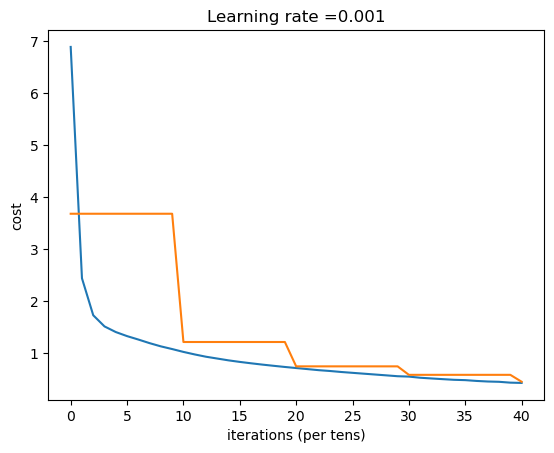

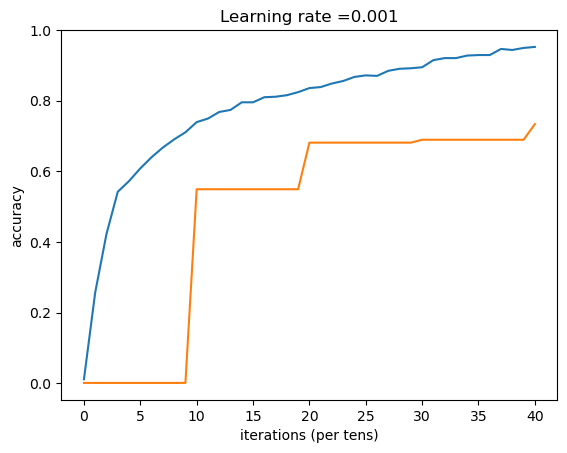

Parameters have been trained!


2023-01-18 03:43:59.471358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [7]:

GCN_mask_TR = sample_mask(np.arange(0,695), ALL_Y.shape[0])
GCN_mask_TE = sample_mask(np.arange(696,10366), ALL_Y.shape[0])

ALL_Y = convert_to_one_hot(ALL_Y - 1, 16)
ALL_Y = ALL_Y.T


parameters, val_acc, features = train_mynetwork(ALL_X, ALL_Y, ALL_L.todense(), GCN_mask_TR, GCN_mask_TE)
sio.savemat('features-GCN.mat', {'features': features})